In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)'
import matplotlib.pyplot as plt
from tensorflow.python.keras.applications import resnet
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.python.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow import keras
# from tensorflow.python.keras.optimizers import Adam
import cv2
import math
from IPython.display import clear_output
%matplotlib inline
import os
import requests

C:\Users\LENOVO\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\LENOVO\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\LENOVO\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [68]:
IMG_SIZE = 224
NUM_EPOCHS = 20
NUM_CLASSES = 2
TRAIN_BATCH_SIZE = 72
TEST_BATCH_SIZE = 1 

In [69]:
def create_model( model_size ):
    my_new_model = Sequential()
    if  model_size == 'L':
        resnet_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
        resnet = ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path)
        resnet.summary()
        my_new_model.add(resnet)
        my_new_model.layers[0].trainable = False
    else:
        vgg_weights_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
        vgg= VGG16(include_top=False, weights=vgg_weights_path ) 
        vgg.summary()
        my_new_model.add(vgg)
        my_new_model.add(GlobalAveragePooling2D())
        my_new_model.layers[0].trainable = False
        
        my_new_model.layers[1].trainable = False
        
    my_new_model.add(Dense(NUM_CLASSES, activation='softmax'))
   
    # Say no to train first layer (ResNet) model. It is already trained
    
    opt = keras.optimizers.Adam()
    my_new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
    return my_new_model

In [70]:
def train_model( model ):
    #data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

    data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
#                                 sear_range=0.01,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=True,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5]
                               )
                                       
    train_generator = data_generator_with_aug.flow_from_directory(
            'train',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical',shuffle=True)
    
   
    validation_generator = data_generator_with_aug.flow_from_directory(
            'test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TEST_BATCH_SIZE,
            shuffle = True,
            class_mode='categorical')
    
        
#     y_train = get_labels(train_generator)
#     weights = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
#     dict_weights = { i: weights[i] for i in range(len(weights)) }
       
    H = model.fit(
            train_generator,
            steps_per_epoch=train_generator.n/TRAIN_BATCH_SIZE,
            epochs=NUM_EPOCHS,
            validation_data=validation_generator,
            validation_steps=1,
#             class_weight=dict_weights
                )
    
    plot_history( H, NUM_EPOCHS )
    
    return model, train_generator,validation_generator

In [71]:
def get_label_dict(train_generator ):
# Get label to class_id mapping
    labels = (train_generator.class_indices)
    label_dict = dict((v,k) for k,v in labels.items())
    return  label_dict   

In [72]:
def get_labels( generator ):
    generator.reset()
    labels = []
    for i in range(len(generator)):
        labels.extend(np.array(generator[i][1]) )
    return np.argmax(labels, axis =1)

In [73]:
def plot_history( H, NUM_EPOCHS ):
    plt.style.use("ggplot")
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    
    fig.add_subplot(1, 3, 1)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")

    
    fig.add_subplot(1, 3, 2)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_acc"], label="train_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    fig.add_subplot(1, 3, 3)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="val_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_acc"], label="val_acc")
    plt.title("Validation Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

    plt.show()
    plt.savefig("plot.png")

In [74]:
def draw_prediction( frame, class_string ):
    x_start = frame.shape[1] -600
    cv2.putText(frame, class_string, (x_start, 75), cv2.FONT_HERSHEY_SIMPLEX, 2.5, (255, 0, 0), 2, cv2.LINE_AA)
    return frame

In [75]:
def prepare_image_for_prediction( img):
   
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    # The below function inserts an additional dimension at the axis position provided
    img = np.expand_dims(img, axis=0)
    # perform pre-processing that was done when resnet model was trained.
    return preprocess_input(img)

In [76]:
model = create_model('L')

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Found 803 images belonging to 2 classes.
Found 75 images belonging to 2 classes.
Epoch 1/20
22/21 [===============================] - 91s 4s/step - loss: 0.1939 - acc: 0.9215 - val_loss: 0.1184 - val_acc: 1.0000
Epoch 2/20
22/21 [===============================] - 78s 4s/step - loss: 0.0699 - acc: 0.9738 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 3/20
22/21 [===============================] - 73s 3s/step - loss: 0.0363 - acc: 0.9900 - val_loss: 6.1989e-06 - val_acc: 1.0000
Epoch 4/20
22/21 [===============================] - 70s 3s/step - loss: 0.0396 - acc: 0.9838 - val_loss: 0.0131 - val_acc: 1.0000
Epoch 5/20
22/21 [===============================] - 63s 3s/step - loss: 0.0470 - acc: 0.9851 - val_loss: 1.0013e-04 - val_acc: 1.0000
Epoch 6/20
22/21 [===============================] - 65s 3s/step - loss: 0.0220 - acc: 0.9938 - val_loss: 7.9898e-04 - val_acc: 1.0000
Epoch 7/20
22/21 [===============================] - 69s 3s/step - loss: 0.0231 - acc: 0.9950 - val_loss: 1.5535 - val_ac

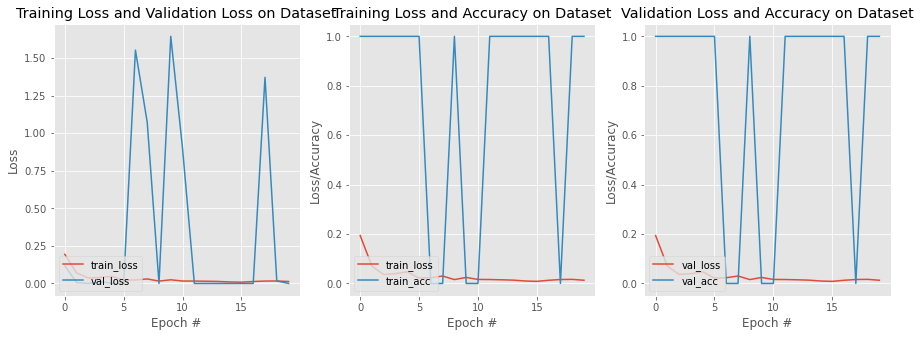

<Figure size 432x288 with 0 Axes>

In [77]:
trained_model_l, train_generator,validation_generator = train_model(model)
label_dict_l = get_label_dict(train_generator)

In [78]:
def get_display_string(pred_class, label_dict):
    txt = ""
    for c, confidence in pred_class:
        txt += label_dict[c]
        if c :
            txt += '['+ str(confidence) +']'
    #print("count="+str(len(pred_class)) + " txt:" + txt)
    return txt

In [15]:
model.save('model.h5')

In [1]:
def sendNotifikasi(messege,phone):
    url = 'https://eu119.chat-api.com/instance217065/sendMessage?token=d1e5g4c9512okglw'
    data = {
        'phone' : phone,
        'body' : messege,
    }
    res = requests.post(url, json=data)
    return res.text

In [79]:
def predict(  model, video_path, filename, label_dict ):
    vs = cv2.VideoCapture(0)
    fps = math.floor(vs.get(cv2.CAP_PROP_FPS))
    ret_val = True
    writer = 0
    print(fps)
    while True:
        ret_val, frame = vs.read()
        if not ret_val:
            break
        resized_frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame_for_pred = prepare_image_for_prediction( resized_frame )
        pred_vec = model.predict(frame_for_pred)
        pred_class =[]
        confidence = np.round(pred_vec.max(),2) 
        
        if confidence > 0.4:
            pc = pred_vec.argmax()
            pred_class.append( (pc, confidence) )
        else:
            pred_class.append( (0, 0) )
        if pred_class:
            txt = get_display_string(pred_class, label_dict)   
            print(txt)
            if txt == 'fire_images':
                frame = draw_prediction( frame, 'Terdeteksi Api' )
                sendNotifikasi('Terdeteksi api,Awas ada kebakaran!!!','6285740332389')
                sendNotifikasi('Terdeteksi api,Awas ada kebakaran!!!','6285728225130')
            else:
                frame = draw_prediction( frame, 'Non fire' )
        cv2.imshow('Frame',frame)
        k = cv2.waitKey(20) & 0xff
        if k == ord('q'):
            break
    cv2.destroyAllWindows()
    vs.release()

In [80]:
video_path = "test2_9.avi"
predict ( model, video_path, 'result_5.avi',  label_dict_l)

30
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
fire_images
non_fire_images[0.92]
non_fire_images[0.89]
non_fire_images[0.9]
non_fire_images[0.9]
non_fire_images[0.73]
fire_images
fire_images
fire_images
fire_images
non_fire_images[0.87]
non_fire_images[0.86]
non_fire_images[0.81]
non_fire_images[0.82]
non_fire_images[0.53]
non_fire_images[0.81]
non_fire_images[0.73]
fire_images
non_fire_images[0.51]
non_fire_images[0.75]
non_fire_images[0.58]
non_fire_images[0.68]
non_fire_images[0.58]
non_fire_images[0.63]
non_fire_images[0.7]
non_fire_images[0.73]
non_fire_images[0.7]
non_fire_images[0.6]
no